In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#!pip install keras
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu
!pip install xlrd==1.2.0
!pip install openpyxl
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: xlrd
    Found existing installation: xlrd 2.0.1
    Uninstalling xlrd-2.0.1:
      Successfully uninstalled xlrd-2.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 14.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time
from collections import Counter

from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

In [ ]:
data = pd.read_csv('SBTC - Sheet1.csv')

In [ ]:
print("Categories:")
print(data.final_label.unique())
category_list=data.final_label.unique()

Categories:
['Physics' 'Chemistry' 'Biology' 'ICT' 'Mathematics' 'Others']


In [ ]:
print("First rows of dataset")
data.head()

First rows of dataset


,ID,text,source,cleantext,label1,label2,label3,final_label
0,1,ভৌত জগৎ মূলত চারটি উপাদানের সমন্বয়ে তৈরি- (১)...,HSC Physics,ভৌত জগৎ মূলত চারটি উপাদানের সমন্বয়ে তৈরি স্থা...,Physics,Physics,Physics,Physics
1,2,বলবিদ্যা বস্তুর উপর বলের ক্রিয়া সংক্রান্ত বিভ...,HSC Physics,বলবিদ্যা বস্তুর উপর বলের ক্রিয়া সংক্রান্ত বিভ...,Physics,Physics,Physics,Physics
2,3,পদার্থের ধর্ম বস্তুর বিভিন্ন গুণ আলোচনা করে।,HSC Physics,পদার্থের ধর্ম বস্তুর বিভিন্ন গুণ আলোচনা করে,Physics,Physics,Physics,Physics
3,4,স্থিতিবিদ্যা স্থিতিশীল বস্তুর উপর বলের ক্রিয়া...,HSC Physics,স্থিতিবিদ্যা স্থিতিশীল বস্তুর উপর বলের ক্রিয়া...,Physics,Physics,Physics,Physics
4,5,গতিবিদ্যা গতিশীল বস্তুর উপর বলের ক্রিয়া আলোচন...,HSC Physics,গতিবিদ্যা গতিশীল বস্তুর উপর বলের ক্রিয়া আলোচন...,Physics,Physics,Physics,Physics


In [ ]:
print("Description of dataset")
data.describe()

Description of dataset


,ID
count,6000.000000
mean,3000.500000
std,1732.195139
min,1.000000
25%,1500.750000
50%,3000.500000
75%,4500.250000
max,6000.000000


In [ ]:
print("Dataframe Information on dataset")
data.info()

Dataframe Information on dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           6000 non-null   int64 
 1   text         6000 non-null   object
 2   source       6000 non-null   object
 3   cleantext    6000 non-null   object
 4   label1       6000 non-null   object
 5   label2       6000 non-null   object
 6   label3       6000 non-null   object
 7   final_label  6000 non-null   object
dtypes: int64(1), object(7)
memory usage: 375.1+ KB


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)
    text = re.sub(r'₀|₁|₂|₃|₄|₅|₆|₇|₈|₉', '', text)
    text = re.sub(r'⁰|¹|²|³|⁴|⁵|⁶|⁷|⁸|⁹|⁻|⁺|ⁿ|ᵗ', '', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-−[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰θ→°π∈∝α≤≥Δβε≠�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
data['cleantext'] = data.text.apply(lambda x: preprocessing(str(x)))
# print some cleaned reviews from the dataset
sample_data = range(5000,6000)
for i in sample_data:
  print(data.cleantext[i])

সনাতন বা আদিম সমাজে মানুষের জীবনযাপন ছিল অত্যন্ত সহজ সরল 
খাবার দাবার কাপড় চোপড় এবং বাড়িঘর এসবই ছিল মানুষের মৌলিক চাহিদা 
মূলত মানুষের কায়িক পরিশ্রম ছিল উৎপাদনের একমাত্র উপকরণ 
দশে মিলে করি কাজ হারিজিতি নাহি লাজ এই ছিল আদিম সমাজের মূলমন্ত্র
উৎপাদন ভোগ ও দৈনন্দিন সংসার পরিচালনার বিদ্যাকেই তখন অর্থনীতি বলা হতো
প্রাচীন ভারতে চতুর্থ খ্রিষ্টপূর্বে কৌটিল্যের অর্থশাস্ত্রে বৃহত্তর পরিসরে সারা দেশের রাজনীতি সমাজ অর্থনীতি ও সামরিক বিষয়ের উপর আলোকপাত করা হয়
দেশের ধনসম্পদ বৃদ্ধি রাষ্ট্রের ক্ষমতা বৃদ্ধি ও বাণিজ্য উদ্বৃত্তকরণের লক্ষ্যে ইংল্যান্ডের ব্যবসায়ীরা বেশি রপ্তানি করত এবং খুব সামান্যই আমদানি করত
ইংল্যান্ডের উৎপাদিত পণ্য পৃথিবীর বিভিন্ন দেশে প্রচুর পরিমাণে রপ্তানি করে মূল্যবান ধাতু সোনা রূপা হীরা ইত্যাদি আমদানি করা হতো 
অষ্টাদশ শতাব্দীর মধ্যভাগে ফরাসিরা সে দেশের ধনী মানুষের বিলাসী জীবনযাপন অতিরিক্ত করারোপ এবং ইংল্যান্ডের বাণিজ্যবাদের বিপক্ষে অবস্থান নিয়ে ভূমিবাদ মতবাদ প্রচার করেন 
ভূমিবাদীদের মতে কৃষিই খনি ও মৎসক্ষেত্রসহ হলো উৎপাদনশীল খাত
অন্যদিকে শিল্প ও বাণিজ্য উভয়ই অনুৎপাদনশীল খাত 

In [ ]:
stop =["অতএব","অথচ","অথবা","অনুযায়ী","অনেক","অনেকে","অনেকেই","অন্তত","অন্য","অবধি","অবশ্য","অর্থাত","আই","আগামী","আগে","আগেই","আছে","আজ","আদ্যভাগে","আপনার","আপনি","আবার","আমরা","আমাকে","আমাদের","আমার","আমি","আর","আরও","ই","ইত্যাদি","ইহা","উচিত","উত্তর","উনি","উপর","উপরে","এ","এঁদের","এঁরা","এই","একই","একটি","একবার","একে","এক্","এখন","এখনও","এখানে","এখানেই","এটা","এটাই","এটি","এত","এতটাই","এতে","এদের","এব","এবং","এবার","এমন","এমনকী","এমনি","এর","এরা","এল","এস","এসে","ঐ","ও","ওঁদের","ওঁর","ওঁরা","ওই","ওকে","ওখানে","ওদের","ওর","ওরা","কখনও","কত","কবে","কমনে","কয়েক","কয়েকটি","করছে","করছেন","করতে","করবে","করবেন","করলে","করলেন","করা","করাই","করায়","করার","করি","করিতে","করিয়া","করিয়ে","করে","করেই","করেছিলেন","করেছে","করেছেন","করেন","কাউকে","কাছ","কাছে","কাজ","কাজে","কারও","কারণ","কি","কিংবা","কিছু","কিছুই","কিন্তু","কী","কে","কেউ","কেউই","কেখা","কেন","কোটি","কোন","কোনও","কোনো","ক্ষেত্রে","কয়েক","খুব","গিয়ে","গিয়েছে","গিয়ে","গুলি","গেছে","গেল","গেলে","গোটা","চলে","চান","চায়","চার","চালু","চেয়ে","চেষ্টা","ছাড়া","ছাড়াও","ছিল","ছিলেন","জন","জনকে","জনের","জন্য","জন্যওজে","জানতে","জানা","জানানো","জানায়","জানিয়ে","জানিয়েছে","জে","জ্নজন","টি","ঠিক","তখন","তত","তথা","তবু","তবে","তা","তাঁকে","তাঁদের","তাঁর","তাঁরা","তাঁাহারা","তাই","তাও","তাকে","তাতে","তাদের","তার","তারপর","তারা","তারৈ","তাহলে","তাহা","তাহাতে","তাহার","তিনঐ","তিনি","তিনিও","তুমি","তুলে","তেমন","তো","তোমার","থাকবে","থাকবেন","থাকা","থাকায়","থাকে","থাকেন","থেকে","থেকেই","থেকেও","দিকে","দিতে","দিন","দিয়ে","দিয়েছে","দিয়েছেন","দিলেন","দু","দুই","দুটি","দুটো","দেওয়া","দেওয়ার","দেওয়া","দেখতে","দেখা","দেখে","দেন","দেয়","দ্বারা","ধরা","ধরে","ধামার","নতুন","নয়","না","নাই","নাকি","নাগাদ","নানা","নিজে","নিজেই","নিজেদের","নিজের","নিতে","নিয়ে","নিয়ে","নেই","নেওয়া","নেওয়ার","নেওয়া","নয়","পক্ষে","পর","পরে","পরেই","পরেও","পর্যন্ত","পাওয়া","পাচ","পারি","পারে","পারেন","পি","পেয়ে","পেয়্র্","প্রতি","প্রথম","প্রভৃতি","প্রযন্ত","প্রাথমিক","প্রায়","প্রায়","ফলে","ফিরে","ফের","বক্তব্য","বদলে","বন","বরং","বলতে","বলল","বললেন","বলা","বলে","বলেছেন","বলেন","বসে","বহু","বা","বাদে","বার","বি","বিনা","বিভিন্ন","বিশেষ","বিষয়টি","বেশ","বেশি","ব্যবহার","ব্যাপারে","ভাবে","ভাবেই","মতো","মতোই","মধ্যভাগে","মধ্যে","মধ্যেই","মধ্যেও","মনে","মাত্র","মাধ্যমে","মোট","মোটেই","যখন","যত","যতটা","যথেষ্ট","যদি","যদিও","যা","যাঁর","যাঁরা","যাওয়া","যাওয়ার","যাওয়া","যাকে","যাচ্ছে","যাতে","যাদের","যান","যাবে","যায়","যার","যারা","যিনি","যে","যেখানে","যেতে","যেন","যেমন","র","রকম","রয়েছে","রাখা","রেখে","লক্ষ","শুধু","শুরু","সঙ্গে","সঙ্গেও","সব","সবার","সমস্ত","সম্প্রতি","সহ","সহিত","সাথে","সাধারণ","সামনে","সি","সুতরাং","সে","সেই","সেখান","সেখানে","সেটা","সেটাই","সেটাও","সেটি","স্পষ্ট","স্বয়ং","হইতে","হইবে","হইয়া","হওয়া","হওয়ায়","হওয়ার","হচ্ছে","হত","হতে","হতেই","হন","হবে","হবেন","হয়","হয়তো","হয়নি","হয়ে","হয়েই","হয়েছিল","হয়েছে","হয়েছেন","হল","হলে","হলেই","হলেও","হলো","হাজার","হিসাবে","হৈলে","হোক","হয়"]
display(stop)

['অতএব',
 'অথচ',
 'অথবা',
 'অনুযায়ী',
 'অনেক',
 'অনেকে',
 'অনেকেই',
 'অন্তত',
 'অন্য',
 'অবধি',
 'অবশ্য',
 'অর্থাত',
 'আই',
 'আগামী',
 'আগে',
 'আগেই',
 'আছে',
 'আজ',
 'আদ্যভাগে',
 'আপনার',
 'আপনি',
 'আবার',
 'আমরা',
 'আমাকে',
 'আমাদের',
 'আমার',
 'আমি',
 'আর',
 'আরও',
 'ই',
 'ইত্যাদি',
 'ইহা',
 'উচিত',
 'উত্তর',
 'উনি',
 'উপর',
 'উপরে',
 'এ',
 'এঁদের',
 'এঁরা',
 'এই',
 'একই',
 'একটি',
 'একবার',
 'একে',
 'এক্',
 'এখন',
 'এখনও',
 'এখানে',
 'এখানেই',
 'এটা',
 'এটাই',
 'এটি',
 'এত',
 'এতটাই',
 'এতে',
 'এদের',
 'এব',
 'এবং',
 'এবার',
 'এমন',
 'এমনকী',
 'এমনি',
 'এর',
 'এরা',
 'এল',
 'এস',
 'এসে',
 'ঐ',
 'ও',
 'ওঁদের',
 'ওঁর',
 'ওঁরা',
 'ওই',
 'ওকে',
 'ওখানে',
 'ওদের',
 'ওর',
 'ওরা',
 'কখনও',
 'কত',
 'কবে',
 'কমনে',
 'কয়েক',
 'কয়েকটি',
 'করছে',
 'করছেন',
 'করতে',
 'করবে',
 'করবেন',
 'করলে',
 'করলেন',
 'করা',
 'করাই',
 'করায়',
 'করার',
 'করি',
 'করিতে',
 'করিয়া',
 'করিয়ে',
 'করে',
 'করেই',
 'করেছিলেন',
 'করেছে',
 'করেছেন',
 'করেন',
 'কাউকে',
 'কাছ',
 'কাছে',
 'কাজ',
 'কাজে',
 'কারও',
 '

In [ ]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]

    out=' '.join(stm)

    return str(out)

In [ ]:
data['cleantext'] = data.cleantext.apply(lambda x: stopwordRemoval(str(x)))
#display(data.cleantext)
sample_data = range(0,1000)
for i in sample_data:
  print(data.cleantext[i])

ভৌত জগৎ মূলত চারটি উপাদানের সমন্বয়ে তৈরি স্থান কাল সময় ভর শক্তি
বলবিদ্যা বস্তুর বলের ক্রিয়া সংক্রান্ত বিষয় আলোচনা
পদার্থের ধর্ম বস্তুর গুণ আলোচনা
স্থিতিবিদ্যা স্থিতিশীল বস্তুর বলের ক্রিয়া আলোচনা
গতিবিদ্যা গতিশীল বস্তুর বলের ক্রিয়া আলোচনা
ধর্ম সকল পদার্থেরই কমবেশি পদার্থের ধর্ম ওজন বিস্তৃতি রোধ স্থিতিস্থাপকতা
ধর্ম সকল পদার্থের পদার্থের ধর্ম তারতা পাততা দৃঢ়তা ভঙ্গুরতা ধর্ম কেবলমাত্র কঠিন পদার্থের বেলায়
সান্দ্রতা তরল বায়বীয় পদার্থের ধর্ম
পৃষ্ঠটান তলটান তরল পদার্থের ধর্ম
তাপ একপ্রকার শক্তি বস্তুতে প্রয়োগ বস্তুটিকে গরম বস্তুটির তাপমাত্রা বৃদ্ধি পায় বর্জন তাপমাত্রা হ্রাস পায়
তত্ত্ব পরীক্ষানিরীক্ষার সাহায্যে প্রমাণিত মূল কথাগুলি উক্তির প্রকাশ বৈজ্ঞানিক সূত্র
সূত্র সময় আবিষ্কর্তার নামানুসারে ওমের সূত্র বয়েলের সূত্র কখনওবা বিষয়ের নামে শক্তির নিত্যতা সূত্র তাপগতিবিদ্যার সূত্র আবিষ্কারক বিষয় উভয়ের নামে নিউটনের গতিসূত্র গ্যালিলিওর পড়ন্ত বস্তুর সূত্র
সকল প্রাকৃতিক সত্য সরাসরি স্পষ্টভাবে প্রমাণ সত্যের সাহায্যে প্রাকৃতিক ঘটনাকে প্রমাণ নীতি
গাণিতিক মডেল সূত্র প্রতিষ্ঠা লক্ষ্যে পূর্ব

Total number of text: 6000


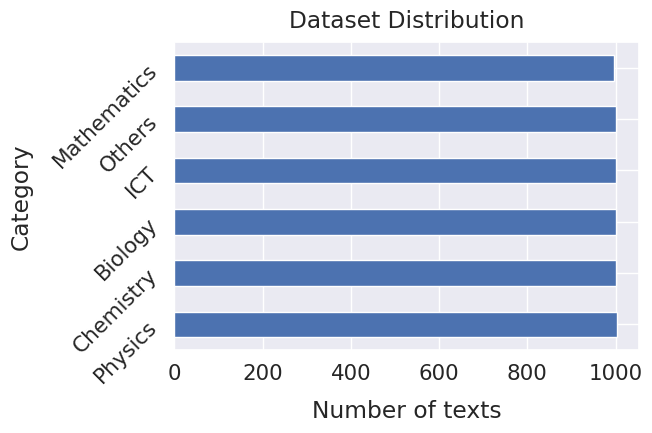

In [ ]:
print(f'Total number of text: {len(data)}')
sns.set(font_scale=1.4)
data['label1'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of texts", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:
def data_summary(data):
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(data.cleantext) for word in t.strip().split()]
    class_label= [k for k,v in data.final_label.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(data[data.final_label==label].cleantext) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return words,u_words,class_label

#call the fucntion
words,u_words,class_names = data_summary(data)


Class Name :  Physics
Number of Words:10959
Number of Unique Words:2609
Most Frequent Words:

বস্তুর	165
বল	144
চৌম্বক	106
তড়িৎ	98
শক্তি	77
সমান	76
মান	72
বস্তু	71
তরঙ্গ	70
ভেক্টর	66

Class Name :  Chemistry
Number of Words:11739
Number of Unique Words:3140
Most Frequent Words:

ইলেকট্রন	102
রাসায়নিক	100
উৎপন্ন	90
তড়িৎ	86
এসিড	78
গ্যাস	78
পরমাণুর	78
জৈব	76
যৌগ	76
বিক্রিয়া	64

Class Name :  Biology
Number of Words:10828
Number of Unique Words:3939
Most Frequent Words:

কোষ	93
সৃষ্টি	75
গঠিত	63
ধরনের	63
প্রক্রিয়ায়	55
কোষের	54
এনজাইম	54
টিস্যু	52
দেহের	49
এক	44

Class Name :  ICT
Number of Words:9924
Number of Unique Words:3215
Most Frequent Words:

ডেটা	181
কম্পিউটার	97
তৈরি	91
নেটওয়ার্ক	88
তথ্য	85
ধরনের	66
প্রোগ্রামিং	54
প্রোগ্রাম	50
কম্পিউটারের	44
টপোলজিতে	43

Class Name :  Mathematics
Number of Words:9530
Number of Unique Words:2122
Most Frequent Words:

মান	151
দুইটি	126
সংখ্যা	118
দশমিক	89
সমান	86
বিন্দুর	80
ফাংশন	73
বিন্দু	71
ফাংশনের	66
সকল	58

Class Name :  Others
Number o

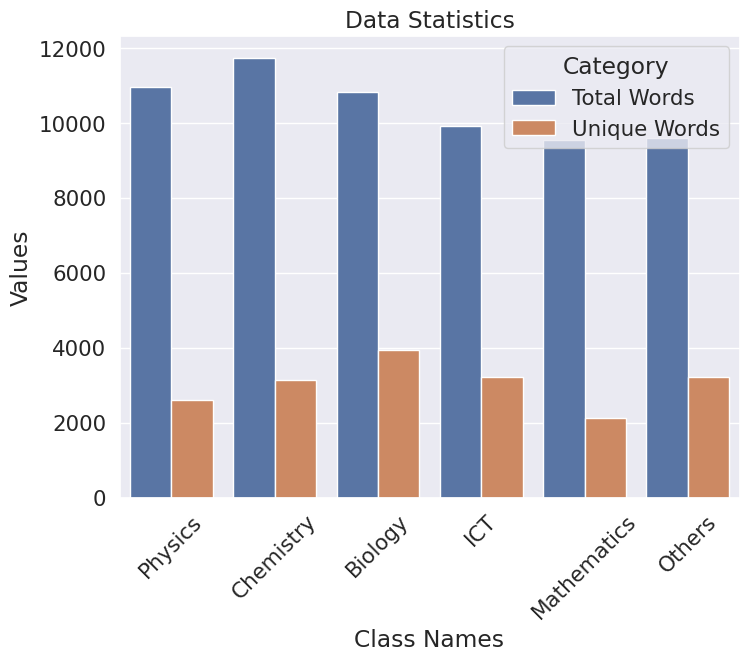

In [ ]:
data_matrix = pd.DataFrame({'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

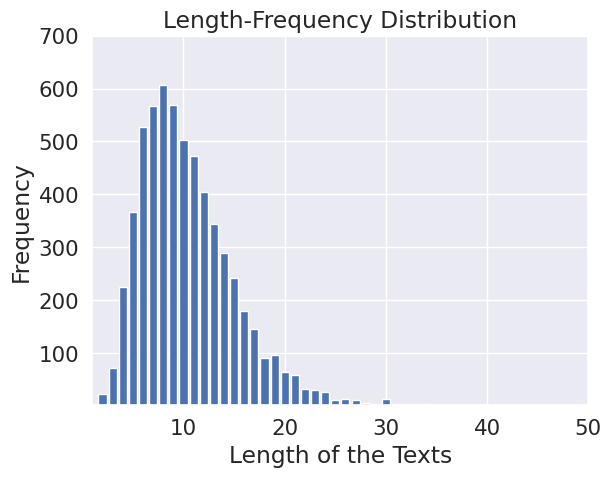

Maximum Length of a text: 42
Minimum Length of a text: 1
Average Length of a text: 10.0


In [ ]:
data['TextLength'] = data.cleantext.apply(lambda x:len(x.split()))
frequency = dict()
for i in data.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 50)
plt.ylim(1, 700)
plt.xlabel('Length of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a text: {max(data.TextLength)}")
print(f"Minimum Length of a text: {min(data.TextLength)}")
print(f"Average Length of a text: {round(np.mean(data.TextLength),0)}")

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Assuming you have your annotations for the three annotators stored in lists 'annotator1', 'annotator2', and 'annotator3'
annotator1 = data.label1  # Example annotations from annotator 1
annotator2 = data.label2  # Example annotations from annotator 2
annotator3 = data.label3  # Example annotations from annotator 3

# Calculate the pairwise kappa scores
kappa_1_2 = cohen_kappa_score(annotator1, annotator2)
kappa_1_3 = cohen_kappa_score(annotator1, annotator3)
kappa_2_3 = cohen_kappa_score(annotator2, annotator3)

# Average the pairwise kappa scores
kappa_avg = (kappa_1_2 + kappa_1_3 + kappa_2_3) / 3

print("Average Kappa Score:", kappa_avg)

Average Kappa Score: 0.9927999401594022


In [ ]:
# Create sets of annotations for each annotator
set_annotator1 = set(annotator1)
set_annotator2 = set(annotator2)
set_annotator3 = set(annotator3)

# Calculate pairwise Jaccard indices
jaccard_1_2 = len(set_annotator1.intersection(set_annotator2)) / len(set_annotator1.union(set_annotator2))
jaccard_1_3 = len(set_annotator1.intersection(set_annotator3)) / len(set_annotator1.union(set_annotator3))
jaccard_2_3 = len(set_annotator2.intersection(set_annotator3)) / len(set_annotator2.union(set_annotator3))

# Average the pairwise Jaccard indices
jaccard_avg = (jaccard_1_2 + jaccard_1_3 + jaccard_2_3) / 3

print("Average Jaccard Index:", jaccard_avg)

Average Jaccard Index: 1.0


In [ ]:
# function to create top 20 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["cleantext"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top20 = esBigram_wordlist.most_common(20)
    top20 = dict(top20)
    data_ngrams = pd.DataFrame(sorted(top20.items(), key=lambda x: x[1])[::-1])
    data_ngrams.columns = ['Ngram','count']
    return data_ngrams


# function to visualize the top 20 n-grams
def show(data):
    display(data.head(20))

In [ ]:
for i in category_list:
    temp=data.loc[data['final_label'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleantext'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    data_unigrams = get_ngrams(temp,1)
    print("\t\t\t====== Unigrams of "+str(i)+"======")
    show(data_unigrams)

			====== Unigrams of Physics======


,Ngram,count
0,"(বস্তুর,)",165
1,"(বল,)",144
2,"(চৌম্বক,)",106
3,"(তড়িৎ,)",98
4,"(শক্তি,)",77
5,"(সমান,)",76
6,"(মান,)",72
7,"(বস্তু,)",71
8,"(তরঙ্গ,)",70
9,"(এক,)",66


			====== Unigrams of Chemistry======


,Ngram,count
0,"(ইলেকট্রন,)",102
1,"(রাসায়নিক,)",100
2,"(উৎপন্ন,)",90
3,"(তড়িৎ,)",86
4,"(পরমাণুর,)",78
5,"(গ্যাস,)",78
6,"(এসিড,)",78
7,"(যৌগ,)",76
8,"(জৈব,)",76
9,"(বিক্রিয়া,)",64


			====== Unigrams of Biology======


,Ngram,count
0,"(কোষ,)",93
1,"(সৃষ্টি,)",75
2,"(ধরনের,)",63
3,"(গঠিত,)",63
4,"(প্রক্রিয়ায়,)",55
5,"(এনজাইম,)",54
6,"(কোষের,)",54
7,"(টিস্যু,)",52
8,"(দেহের,)",49
9,"(নির্দিষ্ট,)",44


			====== Unigrams of ICT======


,Ngram,count
0,"(ডেটা,)",181
1,"(কম্পিউটার,)",97
2,"(তৈরি,)",91
3,"(নেটওয়ার্ক,)",88
4,"(তথ্য,)",85
5,"(ধরনের,)",66
6,"(প্রোগ্রামিং,)",54
7,"(প্রোগ্রাম,)",50
8,"(কম্পিউটারের,)",44
9,"(টপোলজিতে,)",43


			====== Unigrams of Mathematics======


,Ngram,count
0,"(মান,)",151
1,"(দুইটি,)",126
2,"(সংখ্যা,)",118
3,"(দশমিক,)",89
4,"(সমান,)",86
5,"(বিন্দুর,)",80
6,"(ফাংশন,)",73
7,"(বিন্দু,)",71
8,"(ফাংশনের,)",66
9,"(সকল,)",58


			====== Unigrams of Others======


,Ngram,count
0,"(মানচিত্র,)",46
1,"(মানুষ,)",46
2,"(উপন্যাসের,)",44
3,"(শব্দ,)",41
4,"(পৃথিবীর,)",41
5,"(উপন্যাস,)",39
6,"(বাংলা,)",38
7,"(বিষয়,)",37
8,"(ক্রিয়া,)",36
9,"(মানুষের,)",35


In [ ]:
for i in category_list:
    temp=data.loc[data['final_label'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleantext'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    data_bigrams = get_ngrams(temp,2)
    print("\t\t\t====== Bigrams of "+str(i)+" ======")
    show(data_bigrams)

			====== Bigrams of Physics ======


,Ngram,count
0,"(চৌম্বক, ক্ষেত্র)",20
1,"(চৌম্বক, ক্ষেত্রের)",20
2,"(তড়িৎ, প্রবাহ)",20
3,"(বল, প্রয়োগ)",16
4,"(তড়িচ্চালক, শক্তি)",15
5,"(বিভব, পার্থক্য)",14
6,"(বৃদ্ধি, পায়)",14
7,"(তড়িৎ, ক্ষেত্রের)",11
8,"(আকর্ষণ, বল)",11
9,"(ভেক্টর, রাশির)",11


			====== Bigrams of Chemistry ======


,Ngram,count
0,"(তড়িৎ, বিশ্লেষ্য)",21
1,"(বৃদ্ধি, পায়)",19
2,"(জৈব, যৌগের)",19
3,"(জৈব, যৌগ)",17
4,"(গ্যাস, উৎপন্ন)",16
5,"(এক, মোল)",15
6,"(রাসায়নিক, পদার্থের)",14
7,"(রাসায়নিক, পদার্থ)",13
8,"(ইলেকট্রন, যুগল)",12
9,"(হ্রাস, পায়)",11


			====== Bigrams of Biology ======


,Ngram,count
0,"(ভাজক, টিস্যু)",22
1,"(ভাজক, টিস্যুর)",13
2,"(নামে, পরিচিত)",12
3,"(সমন্বয়ে, গঠিত)",12
4,"(এক, একাধিক)",11
5,"(গ্রন্থি, ক্ষরিত)",9
6,"(কোষে, গঠিত)",8
7,"(এক, ধরনের)",8
8,"(যৌন, জনন)",8
9,"(ডিএনএ, অণুর)",8


			====== Bigrams of ICT ======


,Ngram,count
0,"(প্রোগ্রামিং, ভাষা)",19
1,"(এরিয়া, নেটওয়ার্ক)",17
2,"(প্রোগ্রামিং, ভাষায়)",16
3,"(তথ্য, যোগাযোগ)",14
4,"(ইনডেক্স, তৈরি)",11
5,"(ডেটা, টাইপ)",11
6,"(স্টার, টপোলজিতে)",11
7,"(লোকাল, এরিয়া)",11
8,"(ভিন্ন, ভিন্ন)",11
9,"(মেশিন, কোডে)",10


			====== Bigrams of Mathematics ======


,Ngram,count
0,"(আবৃত্ত, দশমিক)",30
1,"(দশমিক, ভগ্নাংশ)",20
2,"(দশমিক, বিন্দুর)",18
3,"(অক্ষ, বরাবর)",18
4,"(মান, দিক)",18
5,"(দশমিক, ভগ্নাংশে)",16
6,"(ভিন্ন, ভিন্ন)",16
7,"(দশমিক, ভগ্নাংশের)",15
8,"(বাস্তব, সংখ্যা)",14
9,"(সারি, কলাম)",13


			====== Bigrams of Others ======


,Ngram,count
0,"(দুতরফা, দাখিলা)",17
1,"(ভাগে, ভাগ)",11
2,"(আবু, জাফর)",10
3,"(সিকান্দার, আবু)",10
4,"(বাংলা, ভাষায়)",10
5,"(আবেগ, শব্দ)",9
6,"(ট্র্যাজেডির, ধর্ম)",8
7,"(সিন্ধুসভ্যতা, যুগের)",8
8,"(ওপর, ভিত্তি)",8
9,"(দাখিলা, পদ্ধতিতে)",8


In [ ]:
for i in category_list:
    temp=data.loc[data['final_label'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleantext'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    data_trigrams = get_ngrams(temp,3)
    print("\t\t\t====== Trigrams of "+str(i)+" ======")
    show(data_trigrams)

			====== Trigrams of Physics ======


,Ngram,count
0,"(স্থিতিস্থাপক, সীমার, বস্তুর)",6
1,"(তড়িচ্চালক, শক্তি, প্রবাহের)",5
2,"(এক, স্থান, স্থানে)",5
3,"(বস্তুর, বল, প্রয়োগ)",5
4,"(ব্যবধান, শূন্যের, কাছাকাছি)",5
5,"(চৌম্বক, ক্ষেত্রের, দিক)",4
6,"(চুম্বক, বিদ্যুৎবাহী, তারের)",4
7,"(বিদ্যুৎ, কোষগুলোর, সমবায়কে)",4
8,"(যুক্ত, বিদ্যুৎ, কোষগুলোর)",4
9,"(একক, চার্জ, একক)",4


			====== Trigrams of Chemistry ======


,Ngram,count
0,"(জৈব, যৌগ, জৈব)",7
1,"(সংকর, অরবিটাল, থাকলে)",6
2,"(নিঃসঙ্গ, ইলেকট্রন, যুগল)",6
3,"(যৌগ, জৈব, যৌগের)",5
4,"(থাকলে, অণুর, আকৃতি)",5
5,"(এক, লিটার, দ্রবণে)",5
6,"(প্রাইমারি, স্ট্যান্ডার্ড, পদার্থের)",5
7,"(মূলক, মূলক, মূলক)",4
8,"(যৌগ, জলীয়, দ্রবণে)",4
9,"(বিক্রিয়ার, সক্রিয়ণ, শক্তি)",4


			====== Trigrams of Biology ======


,Ngram,count
0,"(পিটুইটারি, গ্রন্থি, ক্ষরিত)",6
1,"(প্যারেনকাইমা, কোষে, গঠিত)",6
2,"(গৌণ, যৌন, বৈশিষ্ট্যের)",5
3,"(ভাজক, টিস্যুর, কোষগুলো)",5
4,"(ভাগ, যথা, ক)",5
5,"(তিনভাগে, ভাগ, যথা)",4
6,"(টিস্যুকে, তিনভাগে, ভাগ)",4
7,"(ভাজক, টিস্যুকে, তিনভাগে)",4
8,"(অনুসারে, ভাজক, টিস্যুকে)",4
9,"(আয়ন, অভেদ্য, তল)",3


			====== Trigrams of ICT ======


,Ngram,count
0,"(তথ্য, যোগাযোগ, প্রযুক্তির)",10
1,"(মেশিন, কোডে, রূপান্তর)",5
2,"(লোকাল, এরিয়া, নেটওয়ার্ক)",5
3,"(টুইস্টেড, পেয়ার, ক্যাবল)",5
4,"(সত্য, ফলাফল, মিথ্যা)",4
5,"(ফলাফল, সত্য, ফলাফল)",4
6,"(সংখ্যার, বামপক্ষ, ডানপক্ষের)",4
7,"(মিথ্যা, সংখ্যার, বামপক্ষ)",4
8,"(ফলাফল, মিথ্যা, সংখ্যার)",4
9,"(নেটওয়ার্ক, অচল, পড়ে)",4


			====== Trigrams of Mathematics ======


,Ngram,count
0,"(আবৃত্ত, দশমিক, ভগ্নাংশের)",10
1,"(ভগ্নাংশে, দশমিক, বিন্দুর)",9
2,"(দশমিক, ভগ্নাংশে, দশমিক)",9
3,"(আবৃত্ত, দশমিক, ভগ্নাংশ)",9
4,"(লেখচিত্র, অক্ষ, বরাবর)",8
5,"(লব্ধির, মান, দিক)",7
6,"(সূচিত, লব্ধির, মান)",7
7,"(মান, দিক, ত্রিভুজের)",6
8,"(লম্বাংশের, বীজগণিতীয়, সমষ্টি)",6
9,"(সেট, সৃষ্ট, সঞ্চারপথকে)",6


			====== Trigrams of Others ======


,Ngram,count
0,"(সিকান্দার, আবু, জাফর)",10
1,"(দুতরফা, দাখিলা, পদ্ধতিতে)",8
2,"(মেলোড্রামা, ট্রাজিকমেডি, প্রহসন)",6
3,"(সিন্ধুসভ্যতা, যুগের, অধিবাসীরা)",6
4,"(দুতরফা, দাখিলা, পদ্ধতি)",5
5,"(ভূগোলের, আলোচ্য, বিষয়)",5
6,"(জন্মগ্রহণ, সংগ্রাম, চলবেই)",4
7,"(গ্রামে, জন্মগ্রহণ, সংগ্রাম)",4
8,"(তেঁতুলিয়া, গ্রামে, জন্মগ্রহণ)",4
9,"(উপজেলার, তেঁতুলিয়া, গ্রামে)",4


In [ ]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

import matplotlib.pyplot as plt
from matplotlib import font_manager

# Function for generating word clouds
def generate_wordcloud(data,title):
  data = [tuple(x) for x in data.values]
  wc = WordCloud(font_path="Siyamrupali.ttf",width=1080, height=720, max_words=150,colormap="Dark2").generate_from_frequencies(dict(data))
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap("Word Cloud of "+title,60)),fontsize=13)
  plt.show()

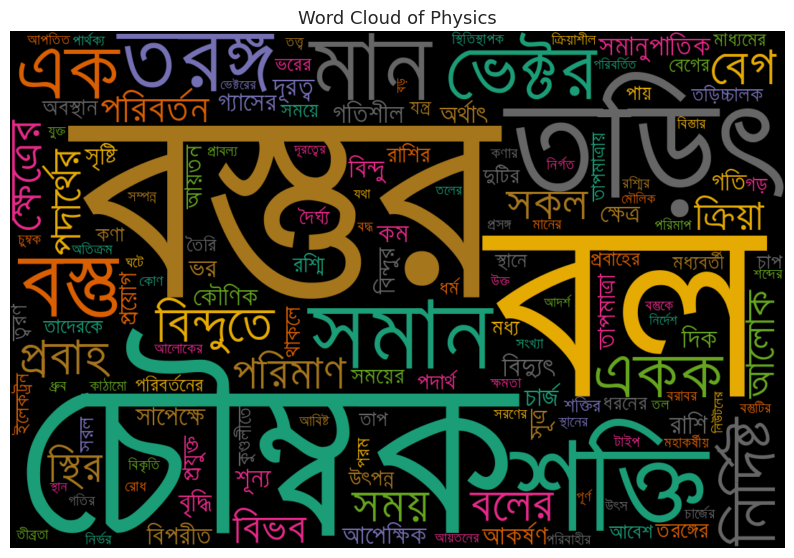

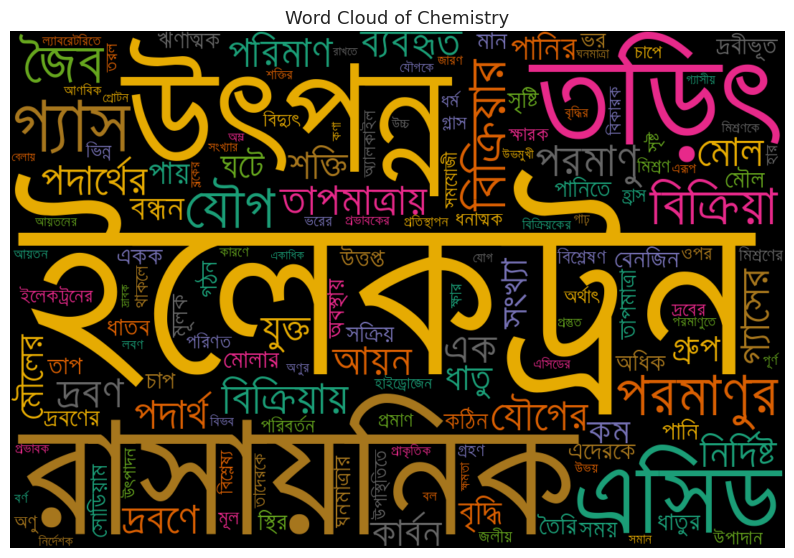

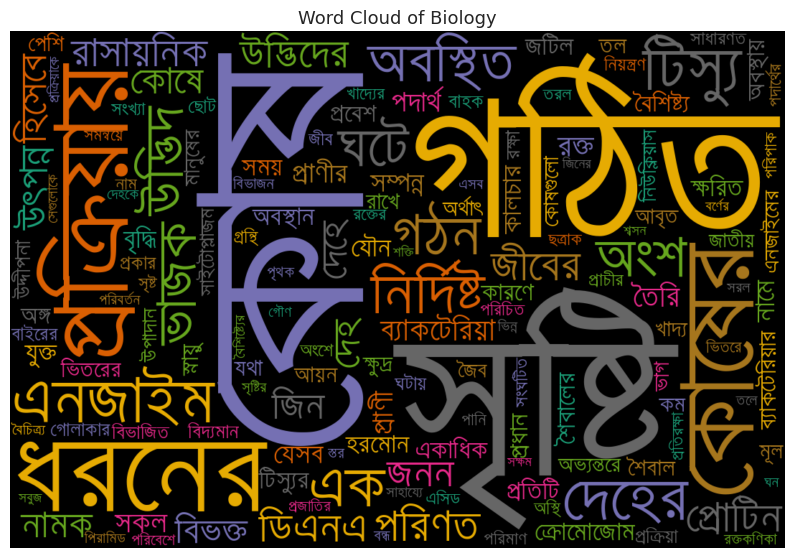

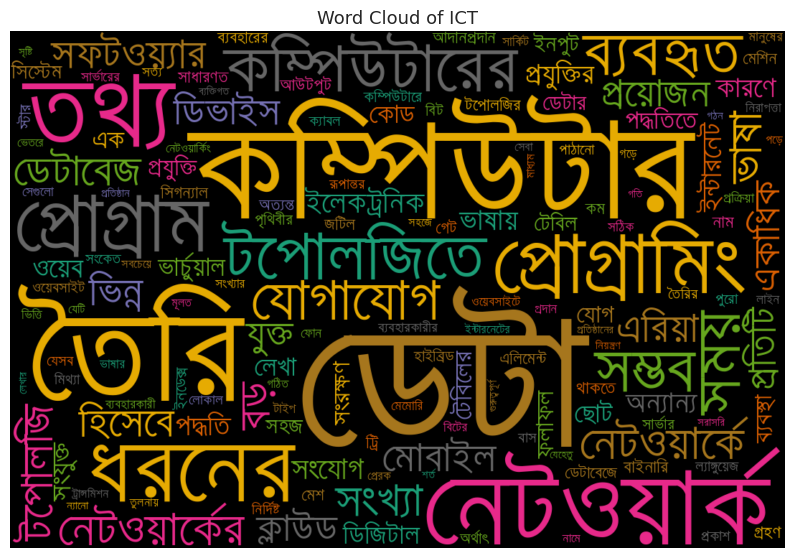

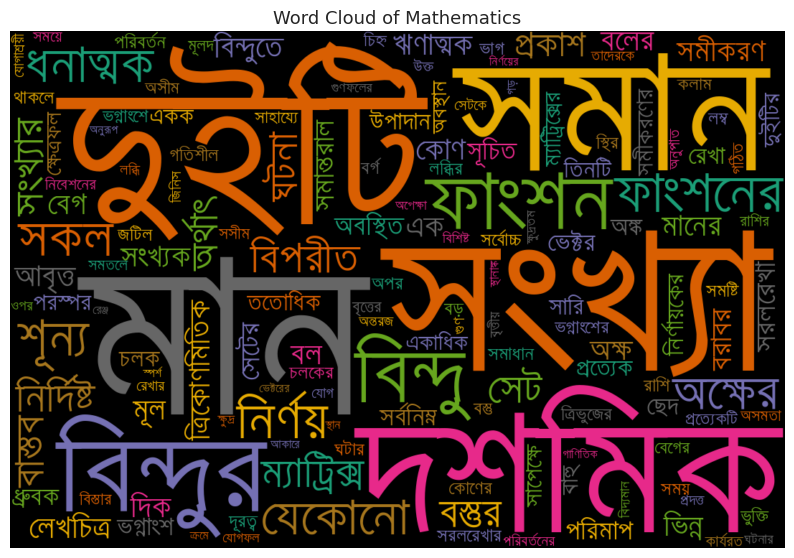

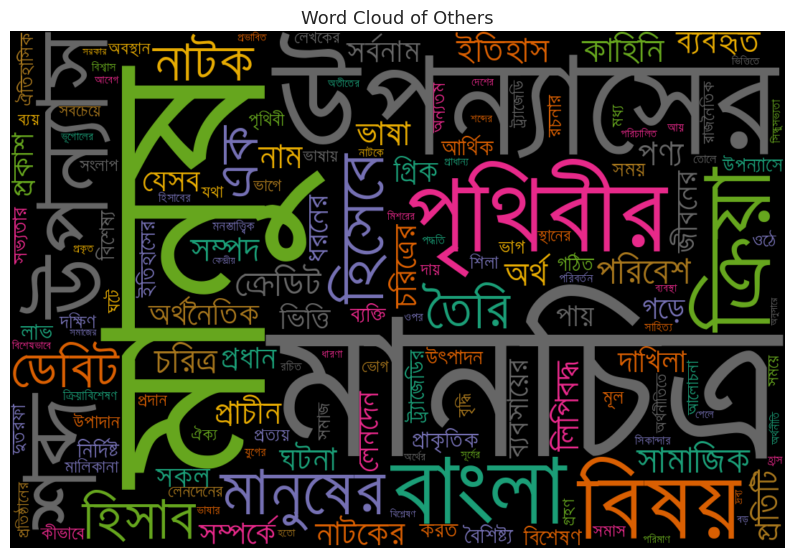

In [ ]:
for i in category_list:
    temp=data.loc[data['final_label'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleantext'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(500000))
    temp.columns = ['Common_words','count']
    generate_wordcloud(temp,str(i))
    print('\n')

In [ ]:
data["label1"]=data.label1.replace({'Physics':0, 'Chemistry':1, 'Biology':2, 'ICT':3, 'Mathematics':4, 'Others':5})
data["label2"]=data.label2.replace({'Physics':0, 'Chemistry':1, 'Biology':2, 'ICT':3, 'Mathematics':4, 'Others':5})
data["label3"]=data.label3.replace({'Physics':0, 'Chemistry':1, 'Biology':2, 'ICT':3, 'Mathematics':4, 'Others':5})
data["final_label"]=data.final_label.replace({'Physics':0, 'Chemistry':1, 'Biology':2, 'ICT':3, 'Mathematics':4, 'Others':5})
print("First rows of dataset")
data.head()

First rows of dataset


,ID,text,source,cleantext,label1,label2,label3,final_label,TextLength
0,1,ভৌত জগৎ মূলত চারটি উপাদানের সমন্বয়ে তৈরি- (১)...,HSC Physics,ভৌত জগৎ মূলত চারটি উপাদানের সমন্বয়ে তৈরি স্থা...,0,0,0,0,12
1,2,বলবিদ্যা বস্তুর উপর বলের ক্রিয়া সংক্রান্ত বিভ...,HSC Physics,বলবিদ্যা বস্তুর বলের ক্রিয়া সংক্রান্ত বিষয় আ...,0,0,0,0,7
2,3,পদার্থের ধর্ম বস্তুর বিভিন্ন গুণ আলোচনা করে।,HSC Physics,পদার্থের ধর্ম বস্তুর গুণ আলোচনা,0,0,0,0,5
3,4,স্থিতিবিদ্যা স্থিতিশীল বস্তুর উপর বলের ক্রিয়া...,HSC Physics,স্থিতিবিদ্যা স্থিতিশীল বস্তুর বলের ক্রিয়া আলোচনা,0,0,0,0,6
4,5,গতিবিদ্যা গতিশীল বস্তুর উপর বলের ক্রিয়া আলোচন...,HSC Physics,গতিবিদ্যা গতিশীল বস্তুর বলের ক্রিয়া আলোচনা,0,0,0,0,6


In [ ]:
# Drop single or multiple columns by specifying column names
data = data.drop(['text', 'source', 'label1', 'label2', 'label3', 'TextLength'], axis=1)
data.head()

,ID,cleantext,final_label
0,1,ভৌত জগৎ মূলত চারটি উপাদানের সমন্বয়ে তৈরি স্থা...,0
1,2,বলবিদ্যা বস্তুর বলের ক্রিয়া সংক্রান্ত বিষয় আ...,0
2,3,পদার্থের ধর্ম বস্তুর গুণ আলোচনা,0
3,4,স্থিতিবিদ্যা স্থিতিশীল বস্তুর বলের ক্রিয়া আলোচনা,0
4,5,গতিবিদ্যা গতিশীল বস্তুর বলের ক্রিয়া আলোচনা,0


In [ ]:
# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (4200, 3)
Validation data shape: (900, 3)
Testing data shape: (900, 3)


In [ ]:
display(train_data)

,ID,cleantext,final_label
4775,4776,বস্তু অতি ঘণিষ্ঠভাবে পরস্পরের সংস্পৃষ্ট স্পর্শ...,4
927,928,পরিবর্তী প্রবাহকে পূর্ণ তরঙ্গ একমুখীকরণ দুভাবে...,0
3258,3259,ধরনের ডিভাইসের শহর গ্রামে পোর্টেবল ব্রডব্যান্ড...,3
45,46,প্ল্যাঙ্কের অভিমত অনুসারে বস্তু শক্তির বিকিরণ ...,0
1260,1261,যেসব মৌলের ইলেকট্রন বিন্যাসে সর্বশেষ ইলেক্ট্রন...,1
...,...,...,...
3772,3773,ভালো সংগঠনের প্রোগ্রামে সঠিক ডেটা স্ট্রাকচার,3
5191,5192,মার্চের পৃথিবী নিজ কক্ষপথে এগিয়ে চলার মেরু ক্...,5
5226,5227,মানচিত্রে দিক দেখানো থাকলে উপরের দিককে দিক বুঝতে,5
5390,5391,ক্রয় ফেরত জাবেদায় ধারে ক্রীত পণ্য ফেরতসংক্রা...,5


In [ ]:
print("Dataframe Information on dataset")
data.info()

Dataframe Information on dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           6000 non-null   int64 
 1   cleantext    6000 non-null   object
 2   final_label  6000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 140.8+ KB


In [ ]:
! pip install tensorboardX pandas simpletransformers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.4 MB/s eta 0:00:00


In [ ]:
!pip install torch

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# Create a custom dataset class for handling the data
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])  # Convert to string in case of numeric data
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask, label

# Load mBERT tokenizer and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=6)

# Add Dropout layer to the model
dropout_prob = 0.1
model.bert.embeddings.dropout = nn.Dropout(dropout_prob)
model.bert.encoder.layer[0].output.dropout = nn.Dropout(dropout_prob)
model.to(device)

# Create data loaders for training, validation, and testing
max_length = 40
train_dataset = CustomDataset(train_data['cleantext'], train_data['final_label'], tokenizer, max_length)
val_dataset = CustomDataset(val_data['cleantext'], val_data['final_label'], tokenizer, max_length)
test_dataset = CustomDataset(test_data['cleantext'], test_data['final_label'], tokenizer, max_length)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define training and evaluation functions and train the model
num_epochs = 20
early_stopping_patience = 5
best_model_path = 'best_model.pt'
best_val_loss = float('inf')
current_patience = 0

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_ids.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for the epoch
    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)

    # Evaluation on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)

            val_loss += loss.item() * input_ids.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    val_loss /= len(val_dataset)
    val_accuracy = val_correct / len(val_dataset)

    # Check for early stopping
    if val_loss < best_val_loss:
     best_val_loss = val_loss
     torch.save(model.state_dict(), best_model_path)
     current_patience = 0
    else:
      current_patience += 1
      if current_patience >= early_stopping_patience:
       print('Early stopping triggered.')
       break

    # Print the training and validation metrics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_correct = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        test_loss += loss.item() * input_ids.size(0)
        test_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate average test loss and accuracy
test_loss /= len(test_dataset)
test_accuracy = test_correct / len(test_dataset)

# Print the test metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Calculate precision, recall, F1 score, and confusion matrix
class_names = ['Physics', 'Chemistry', 'Biology', 'ICT', 'Mathematics', 'Others']
print(classification_report(true_labels, predicted_labels, target_names=class_names))
confusion = confusion_matrix(true_labels, predicted_labels)
confusion_df = pd.DataFrame(confusion, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(confusion_df)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

Epoch 1/20:
Training Loss: 1.0127, Training Accuracy: 0.6440
Validation Loss: 0.5986, Validation Accuracy: 0.7978
Epoch 2/20:
Training Loss: 0.4654, Training Accuracy: 0.8517
Validation Loss: 0.4436, Validation Accuracy: 0.8556
Epoch 3/20:
Training Loss: 0.3151, Training Accuracy: 0.8964
Validation Loss: 0.4082, Validation Accuracy: 0.8767
Epoch 4/20:
Training Loss: 0.2205, Training Accuracy: 0.9271
Validation Loss: 0.3854, Validation Accuracy: 0.8767
Epoch 5/20:
Training Loss: 0.1384, Training Accuracy: 0.9550
Validation Loss: 0.3789, Validation Accuracy: 0.8933
Epoch 6/20:
Training Loss: 0.1142, Training Accuracy: 0.9629
Validation Loss: 0.4042, Validation Accuracy: 0.8922
Epoch 7/20:
Training Loss: 0.0925, Training Accuracy: 0.9710
Validation Loss: 0.4122, Validation Accuracy: 0.8933
Epoch 8/20:
Training Loss: 0.0917, Training Accuracy: 0.9729
Validation Loss: 0.3929, Validation Accuracy: 0.8989
Epoch 9/20:
Training Loss: 0.0597, Training Accuracy: 0.9810
Validation Loss: 0.3981, Va

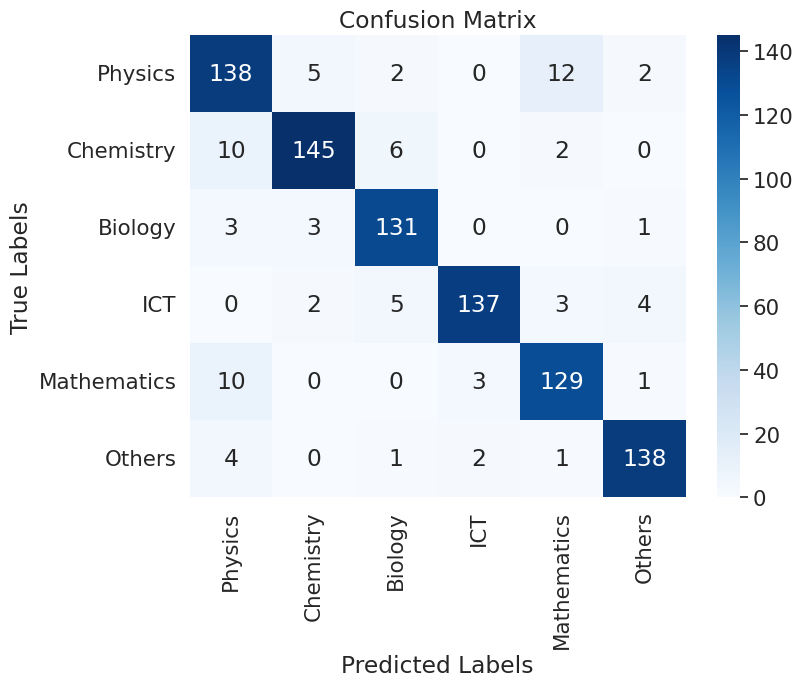

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()